Define values for Data Points

In [279]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install scikit-learn

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# Define Sigma Values

In [303]:
sigma_list = np.linspace(0.1, 4, num = 40 ,dtype=float)
sigma_list=np.round(sigma_list,1)
print(sigma_list)
print(sigma_list.shape)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4. ]
(40,)


# Initialise performance variables

In [304]:
accuracy_list_1=[]
accuracy_list_2=[]
accuracy_list_3=[]


# RBF Network Class

In [305]:
# class RBF_nn(network):
    
#     # Returns list of values that x1,x2 can take
#     def __init__(self,sigma_vals=sigma_list,network,clusters=None):
#         self.sigmas=sigma_list
#         self.clusters=clusters
#         self.network=network
        
#     #Here i=0,1,2...20, returns float
#     def value_func(self,i):
#         return round(-2+0.2*i,2)
    
#     def value_gen(self,max_val):
#         i_list = np.linspace(0, 20, num = (max_val+1),dtype=int)
#         print("Range of i and j is : ",i_list) # Gives the range of i,j
#         values_list=list(map(self.value_func,i_list))
#         print("List of values",values_list)
#         return values_list
    
#     def random_train_samples(self,value_list):
#         train_data = []
#         for num_samples in range(441):
#             row = []  
#             for num_features in range(2):
#                 row.append(random.choice(value_list))
#             train_data.append(row) 
#         train_data=np.array(train_data)
#         return train_data

#     def train_labels(self,train_data):
#         labels=[]       #Output Labels
#         square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
#         for i in range(train_data.shape[0]):
#             square_sum.append(squared_sum(train_data[i]))
#             if squared_sum(train_data[i])<=1:
#                 labels.append(1)
#             else:
#                 labels.append(-1)
#         labels=np.array(labels)
#         labels=np.reshape(labels,(441,1))
#         square_sum=np.array(square_sum)
#         square_sum=np.reshape(square_sum,(441,1))
#         return labels,square_sum

#     def create_df(self,np_array,op_labels,squared_op):
#         columns=['x1','x2']
#         df=pd.DataFrame(np_array,columns=columns)
#         df['Squares']=squared_op
#         df['Output']=op_labels
#         return df

#     def rbf_centres_all(self,train_data):
#         return train_data

#     def gaussian_kernel(self,ip_array, center_vector, sigma):
#         x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
#         return x


#     def rbf_layer_output(self,train_data,centres,sigma):
#         phi = np.zeros((train_data.shape[0], centres.shape[0]))

#         for i in range(train_data.shape[0]):
#             for j in range(centres.shape[0]):
#                 phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
#         return phi

#     def weights(self,rbf_output,op_labels):
#         G_pinv=np.linalg.pinv(rbf_output)
#         D=op_labels
#         W=np.dot(G_pinv,D)
#         return W
    
#      def predict(self,W,G):
#         Y=np.dot(G,W)
#         Y=np.array(Y)
#         Y=np.sign(Y)
#         return Y
    
#     def plot(self,train_data,Y):
#         inside_circle = train_data[Y.flatten() == 1.0]
#         outside_circle = train_data[Y.flatten() == -1.0]

#         # Plotting
#         plt.scatter(inside_circle[:, 0], inside_circle[:, 1], color='blue', label='Inside Circle')
#         plt.scatter(outside_circle[:, 0], outside_circle[:, 1], color='red', label='Outside Circle')
#         plt.xlabel('x1')
#         plt.ylabel('x2')
#         plt.title('Points Inside and Outside Circle')
#         plt.legend()
#         plt.show()
        
#     def accuracy(self, Y , op_labels):
#         accuracy = np.mean(Y == op_labels) * 100
#         return ("Accuracy: {:.2f}%".format(accuracy))
    
#     def calculate_mse(self,predictions, actual_labels):
#         return np.mean((predictions - actual_labels) ** 2)*100

        
    
    


    


    

# Functions to create Dataset

In [306]:
#Here i=0,1,2...20, returns float
def value_func(i):
    return round(-2+0.2*i,2)

# Returns list of values that x1,x2 can take
def value_gen(max_val):
    i_list = np.linspace(0, 20, num = 21,dtype=int)
    print("Range of i and j is : ",i_list) # Gives the range of i,j
    values_list=list(map(value_func,i_list))
    print("List of values",values_list)
    return values_list

#Returns a 441x2 np_array which is the training data. 441 samples with 2 input features each
def random_train_samples(value_list):
    train_data = []
    for num_samples in range(441):
        row = []  
        for num_features in range(2):
            row.append(random.choice(value_list))
        train_data.append(row) 
    train_data=np.array(train_data)
    return train_data

# train_pt is a 1x2 np array, returns int
def squared_sum(train_pt):
    return (train_pt[0]**2)+(train_pt[1]**2)

# Returns a 441x1 np array containing the output labels as per f(x1,x2)
def train_labels(train_data):
    labels=[]       #Output Labels
    square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
    for i in range(train_data.shape[0]):
        square_sum.append(squared_sum(train_data[i]))
        if squared_sum(train_data[i])<=1:
            labels.append(1)
        else:
            labels.append(-1)
    labels=np.array(labels)
    labels=np.reshape(labels,(441,1))
    square_sum=np.array(square_sum)
    square_sum=np.reshape(square_sum,(441,1))
    return labels,square_sum
            




# Functions to create Centres

In [328]:
#returns rbf centres-441x2 matrix
def rbf_centres_all(train_data):
    return train_data

def rbf_centres_random(train_data):
    rbf_centres =np.empty((150,2))
    for num_samples in range(150):
        rbf_centres[num_samples]=random.choice(train_data)
    return rbf_centres

def rbf_centres_kmeans(train_data,K):
    kmeans = KMeans(n_clusters=K,n_init='auto').fit(train_data)
    centres=kmeans.cluster_centers_
    return centres


# Functions for Interpolation

In [308]:
def gaussian_kernel(ip_array, center_vector, sigma):
    x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
    return x



def rbf(train_data,centres,sigma):
    phi = np.zeros((train_data.shape[0], centres.shape[0]))
    for i in range(train_data.shape[0]):
        for j in range(centres.shape[0]):
            phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
    return phi

def weights(rbf_output,op_labels):
    G_pinv=np.linalg.pinv(rbf_output)
    D=op_labels
    W=np.dot(G_pinv,D)
#     print(" Shape of W is : ",W.shape)
    return W

def predict(W,G):
#     Y=np.dot(W.T,G)
    Y=np.dot(G,W)
    Y=np.array(Y)
    Y=np.sign(Y)
#     print("Shape of Y is:",Y.shape)
    return Y


# Functions to evaluate performance

In [309]:
def calculate_accuracy(pred_op,actual_op):
    accuracy = np.mean(pred_op == actual_op) * 100
    return accuracy

def calculate_mse(pred_op,actual_op):
    mse= np.mean((pred_op - actual_op) ** 2)*100


# Functions to visualise data

In [310]:
def plot(train_data,labels,ptype):
    inside_circle = train_data[labels.flatten() == 1.0]
    outside_circle = train_data[labels.flatten() == -1.0]
    plot_type={1:"Train Points",2:"RBF-All",3:"RBF-Random",4:"RBF-KMeans"}

    # Plotting
    plt.scatter(inside_circle[:, 0], inside_circle[:, 1], color='blue', label='Inside Circle')
    plt.scatter(outside_circle[:, 0], outside_circle[:, 1], color='red', label='Outside Circle')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Points Inside and Outside Circle'+ plot_type[ptype])
    plt.legend()
    plt.show()

In [311]:
def acc_plot(acc_list,sig_list):
    plt.plot(sig_list,acc_list)
    
    plt.xlabel('Sigma')
    plt.ylabel('Accuracy in %')
    plt.title('Sigma v/s Accuracy Graph')

In [337]:
def comp_plot(acc_list_1,acc_list_2,acc_list_3,sig_list):
    plt.plot(sig_list,acc_list_1,color="red",label="Q1")
    plt.plot(sig_list,acc_list_2,color="blue",label="Q2")
    plt.plot(sig_list,acc_list_3,color="green",label="Q3")
    
    plt.xlabel('Sigma')
    plt.ylabel('Accuracy in %')
    plt.title('Sigma v/s Accuracy Graph')

# RBF Function

In [329]:
def RBF_NN(train_data,op_labels,sigma,quest,K=None):
    if quest==1:
        rbf_centres=rbf_centres_all(train_data)
    elif quest==2:
        rbf_centres=rbf_centres_random(train_data)
    elif quest==3:
        rbf_centres=rbf_centres_kmeans(train_data,K)
        
    rbf_output=rbf(train_data,rbf_centres,sigma)
    W=weights(rbf_output,op_labels)
    Y=predict(W,rbf_output)
    
    accuracy=calculate_accuracy(Y,op_labels)
    if quest==1:
        accuracy_list_1.append(accuracy)
    elif quest==2:
        accuracy_list_2.append(accuracy)
    elif quest==3:
        accuracy_list_3.append(accuracy)
        
#     plot(train_data,Y,2)


## Training Data

### List of values allowed

In [313]:
values_list=value_gen(20)

Range of i and j is :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
List of values [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


### Save Training Samples

In [314]:
#Save train_data
train_data=random_train_samples(values_list)
data_df=pd.DataFrame(train_data,columns=['x1','x2'])


### Compute Actual Output Labels

In [315]:
# Save actual output labels and squared sum of x1, x2
op_labels,squared_op=train_labels(train_data)
print("Shape of Output labels is :",op_labels.shape)

data_df['(x1^2) + (x2^2)']=squared_op
data_df['Actual O/P']=op_labels
        

Shape of Output labels is : (441, 1)


### Display Training Data

In [316]:
# Training Data Frame
data_df

,x1,x2,(x1^2) + (x2^2),Actual O/P
0,-1.8,1.2,4.68,-1
1,-2.0,-1.0,5.00,-1
2,1.4,0.8,2.60,-1
3,1.8,1.0,4.24,-1
4,-0.2,0.2,0.08,1
...,...,...,...,...
436,0.4,0.6,0.52,1
437,1.6,-1.2,4.00,-1
438,-0.6,2.0,4.36,-1
439,-0.6,1.6,2.92,-1


### Training Data Plot

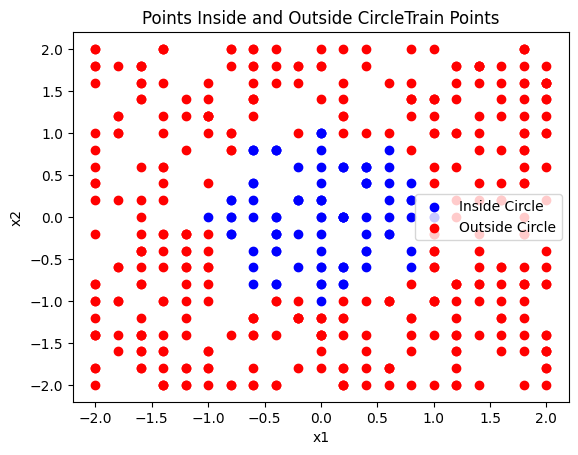

In [317]:
plot(train_data,op_labels,1)

## Question 1

In [318]:
for sigma in sigma_list:
    RBF_NN(train_data,op_labels,sigma,1)

In [319]:
accuracy_list_1

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.09297052154194,
 99.09297052154194,
 98.63945578231292,
 99.09297052154194,
 98.4126984126984,
 98.63945578231292,
 98.4126984126984,
 98.4126984126984,
 99.09297052154194,
 98.63945578231292,
 98.86621315192744,
 98.1859410430839,
 98.1859410430839,
 97.95918367346938,
 97.95918367346938,
 98.1859410430839,
 98.86621315192744,
 98.63945578231292,
 98.86621315192744,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292]

In [320]:
len(accuracy_list_1)

40

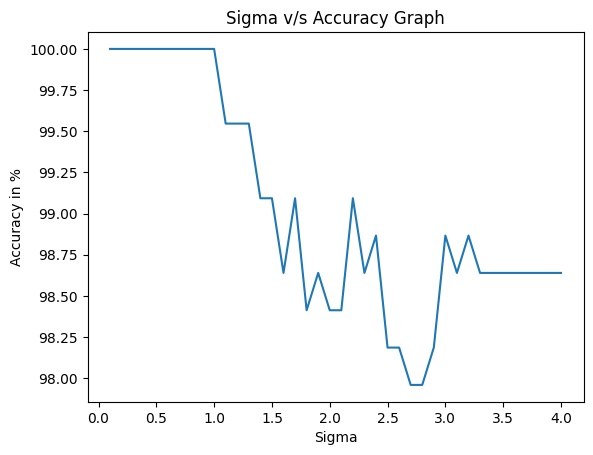

In [321]:
acc_plot(accuracy_list_1,sigma_list)

## Question 2


In [322]:
for sigma in sigma_list:
    RBF_NN(train_data,op_labels,sigma,2)

In [323]:
accuracy_list_2

[96.5986394557823,
 98.63945578231292,
 99.54648526077098,
 99.54648526077098,
 99.31972789115646,
 99.31972789115646,
 99.09297052154194,
 99.09297052154194,
 99.31972789115646,
 98.63945578231292,
 99.09297052154194,
 99.09297052154194,
 99.09297052154194,
 98.63945578231292,
 99.09297052154194,
 98.4126984126984,
 98.4126984126984,
 98.4126984126984,
 98.63945578231292,
 98.63945578231292,
 99.09297052154194,
 98.86621315192744,
 98.1859410430839,
 98.1859410430839,
 98.4126984126984,
 97.95918367346938,
 98.4126984126984,
 98.63945578231292,
 98.1859410430839,
 98.4126984126984,
 98.86621315192744,
 98.63945578231292,
 98.4126984126984,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292]

In [324]:
len(accuracy_list_2)

40

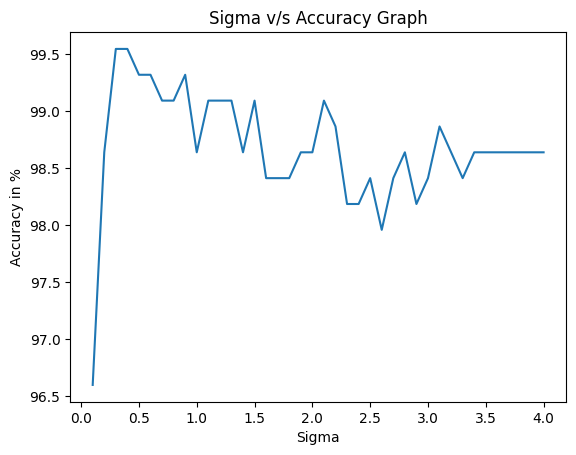

In [326]:
acc_plot(accuracy_list_2,sigma_list)

## Question 3

In [330]:
for sigma in sigma_list:
    RBF_NN(train_data,op_labels,sigma,3,K=120)

In [331]:
accuracy_list_3

[98.4126984126984,
 99.09297052154194,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.09297052154194,
 99.09297052154194,
 99.09297052154194,
 99.09297052154194,
 98.63945578231292,
 98.63945578231292,
 99.09297052154194,
 98.63945578231292,
 98.63945578231292,
 98.4126984126984,
 98.63945578231292,
 98.63945578231292,
 99.09297052154194,
 98.63945578231292,
 98.86621315192744,
 98.1859410430839,
 98.1859410430839,
 98.1859410430839,
 98.1859410430839,
 98.63945578231292,
 98.86621315192744,
 98.63945578231292,
 98.1859410430839,
 98.63945578231292,
 98.4126984126984,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292,
 98.63945578231292]

In [332]:
len(accuracy_list_3)

40

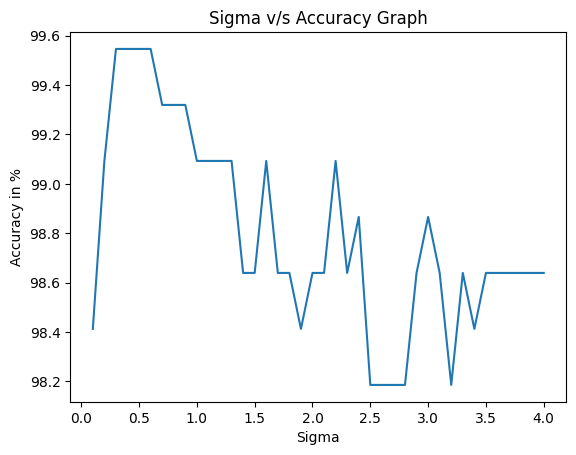

In [333]:
acc_plot(accuracy_list_3,sigma_list)

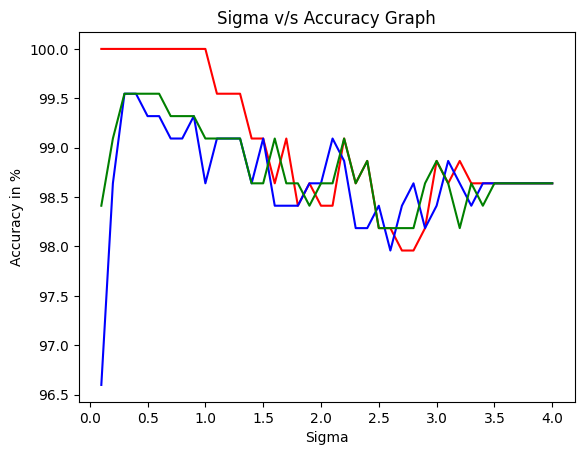

In [338]:
comp_plot(accuracy_list_1,accuracy_list_2,accuracy_list_3,sigma_list)